# Predizioni second wave

- si focalizza sulla second wave
- si analizza come va l'esponenziale e da li si estrapolano le tendenze per altre misure (es. terapie intensive)

In [1]:
import pickle as pkl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from aidam.math_utils import moving_function_rev1
#from aidam.aicharts import get_subplot_cells_sequence, confplot_ax,auto_grid_shape
from aidam.faga.curve_fit import FagaCurveFit
from datetime import datetime, timedelta
from aidam.miscellanea_utils import find_matlabstyle

## Lettura dati

In [2]:
data_file='stored_data.pkl'

infile=open(data_file,'rb')
trend=pkl.load(infile)
regioni=pkl.load(infile)
giorni=pkl.load(infile)
giorno_settimana=pkl.load(infile)
popolazione=pkl.load(infile)
posti_ti_covid=pkl.load(infile)
posti_ti_antecovid=pkl.load(infile)
infile.close()

day_counter=list(range(len(giorni)))

print('Giorni osservati: %d'%len(giorni))
print('Primo giorno: %s'%giorni[0])
print('Ultimo giorno: %s'%giorni[-1])

Giorni osservati: 252
Primo giorno: 2020-02-24T18:00:00
Ultimo giorno: 2020-11-01T17:00:00


## Estrapolazione second wave

Inizio nominale second wave: 2020-09-11T17:00:00
Valore deceduti_giornalieri a inizio second wave: 10.000000


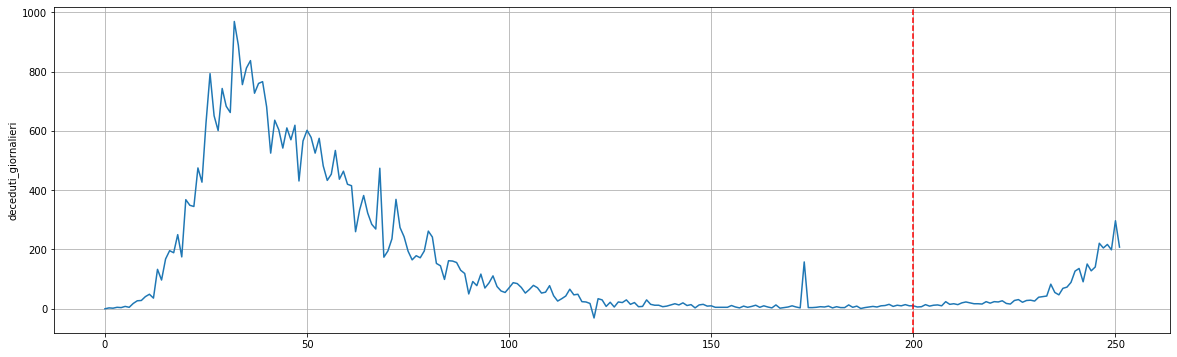

In [19]:
indicatore='deceduti_giornalieri'

# giorno di inizio second wave
sw_start=200

print('Inizio nominale second wave: %s'%giorni[sw_start])


fig,ax=plt.subplots(1,figsize=(20,6))
ax.plot(day_counter,trend[indicatore]['Italia'])
ax.grid()
ax.set_ylabel(indicatore)
ax.axvline(sw_start,c='r',ls='--')


Y=trend[indicatore]['Italia'][sw_start:]


print('Valore %s a inizio second wave: %f'%(indicatore,trend[indicatore]['Italia'][sw_start]))

## Fitting con esponenziale


### Definizione funzione base **generica esponenziale** e relativo dominio

$y=y0+ak^{bt}$

In [20]:
def generic_expo(t,y0,a,k,b):
    return y0+a*k**(b*t)


if indicatore=='totale_positivi':
    dominio=np.array([[10000,0,0,0],
                 [15000,50,10,2]])

if indicatore=='terapia_intensiva':
    dominio=np.array([[40,0,1,0],
                 [150,2,3,1]])

if indicatore=='deceduti_giornalieri':
    dominio=np.array([[0,0,1,0],
                     [15,20,2,15]])
    

## Fitting con FagaCurveFit

In [21]:
days_training=len(Y)

modello_usato=generic_expo

def error_measure(predicted,actual):
    #return np.nanmean(np.abs(predicted-actual))+np.nanstd(np.abs(predicted-actual))
    #return 0.5*np.mean(np.abs(predicted-actual))+0.5*np.mean(np.abs(predicted[-3:]-actual[-3:]))
    return 0.7*np.mean(np.abs(predicted[:-30]-actual[:-30]))+0.15*np.mean(np.abs(predicted[-14:-7]-actual[-14:-7]))+0.15*np.mean(np.abs(predicted[-7:]-actual[-7:]))
    #return np.percentile(np.abs(predicted-actual),80)+np.mean(np.abs(predicted-actual))
    #return np.nanmean(np.abs(predicted-actual))
    
def error_measure_with_first_derivative(predicted,actual):
    return np.nanmean(np.abs(predicted-actual))+np.nanmean(np.abs(np.diff(predicted)-np.diff(actual)))

np.random.seed(42)
    
fcf=FagaCurveFit()

fcf.fit(modello_usato, 
        np.arange(days_training),
        Y,
        dominio,
        ga_generations=3000, ga_population=100,print_info=200,
        error_function=error_measure,
        num_mutations=1)

Welcome to FagaCurveFit!
Gen:     0 BestAll: 3.859 BestGen: 3.859  BioDiv: 3.7
Gen:   200 BestAll: 7.129 BestGen: 7.129  AveFit: 6.283
Gen:   400 BestAll: 7.129 BestGen: 7.129  AveFit: 6.385
Gen:   600 BestAll: 7.129 BestGen: 7.129  AveFit: 5.894
Gen:   800 BestAll: 7.129 BestGen: 7.129  AveFit: 5.824
Gen:  1000 BestAll: 7.129 BestGen: 7.129  AveFit: 6.243
Gen:  1200 BestAll: 7.129 BestGen: 7.129  AveFit: 6.11
Gen:  1400 BestAll: 7.134 BestGen: 7.134  AveFit: 6.033
Gen:  1600 BestAll: 7.135 BestGen: 7.135  AveFit: 5.551
Gen:  1800 BestAll: 7.135 BestGen: 7.135  AveFit: 6.271
Gen:  2000 BestAll: 7.135 BestGen: 7.135  AveFit: 6.335
Gen:  2200 BestAll: 7.135 BestGen: 7.135  AveFit: 5.714
Gen:  2400 BestAll: 7.135 BestGen: 7.135  AveFit: 5.766
Gen:  2600 BestAll: 7.135 BestGen: 7.135  AveFit: 6.084
Gen:  2800 BestAll: 7.135 BestGen: 7.135  AveFit: 6.536
Gen:  3000 BestAll: 7.135 BestGen: 7.135  AveFit: 3.665


In [6]:
solution=fcf.opt_params
solution

# Attualmente positivi con generic expo
#array([1.39326059e+04, 4.98324965e+01, 1.11242163e+00, 8.32977305e-01])

# TI con generic expo
#array([99.98047255,  1.3571392 ,  1.48483514,  0.27450699])

array([54.88585407,  1.55379798,  2.39021662,  0.08075265])

### Simulazione

In [14]:
simulation_days=np.arange(len(Y)+20)
y_pred=np.array(list(map(lambda x:modello_usato(x,*solution),simulation_days)))

Preparazione date

- creo il giorno 0 nel formato *datetime* per poi creare i nuovi plot su questa base
- creo una lista di giorni (in formato di stringhe) partendo dal giorno0

In [15]:
giorno0=datetime.strptime(giorni[sw_start][0:10], "%Y-%m-%d")
str_giorni=[]
for d in range(200):
    str_giorni.append((giorno0+timedelta(d)).strftime("%Y-%m-%d"))
str_giorni=np.array(str_giorni)

oggi=datetime.strftime(datetime.now(), "%Y-%m-%d")
indice_oggi=find_matlabstyle(str_giorni,lambda x:x==oggi)[0]

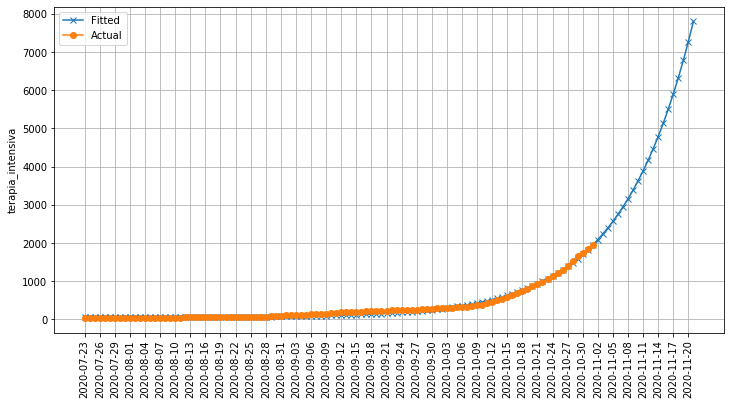

In [16]:
fig,ax=plt.subplots(1,figsize=(12,6))
ax.plot(simulation_days,y_pred,label='Fitted',marker='x')
ax.plot(range(len(Y)),Y,label='Actual',marker='o')
ax.grid()
ax.set_xticks(list(range(0,len(simulation_days),3)))
ax.set_xticklabels(str_giorni[list(range(0,len(simulation_days),3))],rotation=90)

ax.set_ylabel(indicatore)
ax.legend()


In [17]:
for d in simulation_days:
    if d<len(Y):
        print('[%3d]  %s  Act: %6d Pred: %.1f'%(d,str_giorni[d],Y[d],y_pred[d]))
    else:
        print('[%3d]  %s  Act: %6d Pred: %.1f'%(d,str_giorni[d],0,y_pred[d]))   

[  0]  2020-07-23  Act:     49 Pred: 56.4
[  1]  2020-07-24  Act:     46 Pred: 56.6
[  2]  2020-07-25  Act:     41 Pred: 56.7
[  3]  2020-07-26  Act:     44 Pred: 56.8
[  4]  2020-07-27  Act:     45 Pred: 56.9
[  5]  2020-07-28  Act:     40 Pred: 57.1
[  6]  2020-07-29  Act:     38 Pred: 57.3
[  7]  2020-07-30  Act:     47 Pred: 57.4
[  8]  2020-07-31  Act:     41 Pred: 57.6
[  9]  2020-08-01  Act:     43 Pred: 57.8
[ 10]  2020-08-02  Act:     42 Pred: 58.0
[ 11]  2020-08-03  Act:     41 Pred: 58.3
[ 12]  2020-08-04  Act:     41 Pred: 58.5
[ 13]  2020-08-05  Act:     41 Pred: 58.8
[ 14]  2020-08-06  Act:     42 Pred: 59.0
[ 15]  2020-08-07  Act:     42 Pred: 59.4
[ 16]  2020-08-08  Act:     43 Pred: 59.7
[ 17]  2020-08-09  Act:     45 Pred: 60.0
[ 18]  2020-08-10  Act:     46 Pred: 60.4
[ 19]  2020-08-11  Act:     49 Pred: 60.8
[ 20]  2020-08-12  Act:     53 Pred: 61.2
[ 21]  2020-08-13  Act:     55 Pred: 61.7
[ 22]  2020-08-14  Act:     56 Pred: 62.2
[ 23]  2020-08-15  Act:     55 Pre